Homework
- Fine-tune a model on the SAMSum dataset. See if you can beat the book's Pegasus results.
- Compare and contrast a modern instruct LLM (ChatGPT, Bing AI, Google Bard, OpenAssistant, etc) against neural summarization models using Summary Explorer https://tldr.webis.de/.

Additional Resources
- Summary Explorer: Visualizing the State of the Art in Text Summarization Paper: https://arxiv.org/abs/2108.01879 Site: https://tldr.webis.de/
- Hugging Face Course: Summarization https://huggingface.co/learn/nlp-course/chapter7/5
- Text Summarization with fastai+blurr https://ohmeow.com/posts/2020/05/23/text-generation-with-blurr.html
- News Summarization and Evaluation in the Era of GPT-3 https://arxiv.org/abs/2209.12356
- How well do you know your summarization datasets? https://arxiv.org/abs/2106.11388 

--- Benjamin

In [ ]:
#@title Install requirements

# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
# from install import *
# install_requirements(is_chapter6=True)

!pip install torch torchvision torchaudio torchtext transformers>=4.28.1 datasets>=2.11.0 tokenizers>=0.13.3 sentencepiece optuna scikit-learn onnxruntime matplotlib ipywidgets jupyterlab umap-learn seqeval nltk sacrebleu py7zr nlpaug scikit-multilearn psutil accelerate
!pip install rouge-score bertviz

fatal: destination path 'notebooks' already exists and is not an empty directory.
/content/notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#hide
from utils import *
setup_chapter()

Using transformers v4.29.2
Using datasets v2.12.0


In [ ]:
# hide
from transformers import pipeline, set_seed

# Summarization

## The CNN/DailyMail Dataset

In [ ]:
#hide_output
from datasets import load_dataset

dataset = load_dataset("samsum")
print(f"Features: {dataset['train'].column_names}")

  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['id', 'dialogue', 'summary']


In [ ]:
sample = dataset["train"][1]
print(f"""
Dialogue (excerpt of 500 characters, total length: {len(sample["dialogue"])}):
""")
print(sample["dialogue"][:500])
print(f'\nSummary (length: {len(sample["summary"])}):')
print(sample["summary"])


Dialogue (excerpt of 500 characters, total length: 111):

Olivia: Who are you voting for in this election?
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

Summary (length: 61):
Olivia and Olivier are voting for liberals in this election.


## Text Summarization Pipelines

In [ ]:
sample_text = dataset["train"][1]["dialogue"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
#hide_output
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline


In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [ ]:
#hide_output
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-large")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

In [ ]:
#hide_output
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### BART

In [ ]:
#hide_output
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

In [ ]:
#hide_output
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

## Comparing Different Summaries

In [ ]:
# Entire training example
print(dataset["train"][1]["dialogue"])

Olivia: Who are you voting for in this election?
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great


In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["summary"])
print("-"*50)

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("-"*50)

GROUND TRUTH
Olivia and Olivier are voting for liberals in this election.
--------------------------------------------------
BASELINE
Olivia: Who are you voting for in this election?
Oliver: Liberals as always.
Olivia: Me too!!
--------------------------------------------------
GPT2
*Oliver is pissed.
He's pissed because he feels like he's losing, and feels like the world is
against him, and he has no one to blame but himself
If you missed yesterday's podcast, " The Politics of Pity," follow me on Twitter
: @lululemon_
*TL;DR: I talk to Olivia, who is also an athlete, about her plans for the
upcoming season of "The Olympians", and how she feels being a vegan in America
compares to becoming a vegan in Canada.
Olivia is also really good at English.
:)
--------------------------------------------------
T5
liberals as always - who are you voting for in this election?
olivia: i'm voting for the liberals .
nick clegg is a conservative .
--------------------------------------------------
BART

## Measuring the Quality of Generated Text

### BLEU

In [ ]:
# hide_output
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-11-0549c1f56ded>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [ ]:
# hide_output
rouge_metric = load_metric("rouge")

In [ ]:
reference = dataset["train"][1]["summary"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.615385,0.250000,0.538462,0.615385
gpt2,0.080808,0.000000,0.060606,0.060606
t5,0.484848,0.193548,0.363636,0.484848
bart,0.226415,0.078431,0.188679,0.226415
pegasus,0.482759,0.222222,0.413793,0.413793


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [ ]:
# hide
# ignore this cell it is only to be able to start running the notebook here
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

dataset = load_dataset("samsum")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="dialogue", 
                                column_summary="summary"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
num_test = min(1000, len(dataset["test"]))
num_test

819

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(num_test))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.297284,0.086142,0.229164,0.267011


In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="dialogue", 
                               column_summary="summary"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [ ]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [19:05<00:00, 11.12s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296443,0.087574,0.22941,0.229484


In [ ]:
# hide_input 
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296443,0.087574,0.22941,0.229484


## Training a Summarization Model

In [ ]:
# hide_output
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [ ]:
# hide_input
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### Evaluating PEGASUS on SAMSum

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Summary:
Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah asks Larry.
Amanda asks Larry to text him. Hannah says she'll text him back. Hannah calls it
a day and says she's going to go home. Hannah: "Bye bye"


In [ ]:
# hide_output
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [19:12<00:00, 11.19s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.29611,0.087514,0.229251,0.229274


In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.29611,0.087514,0.229251,0.229274


### Fine-Tuning PEGASUS

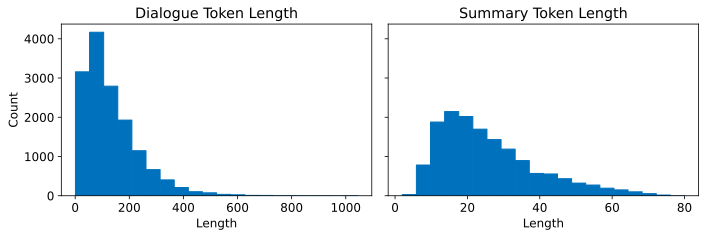

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
#hide_output
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
#hide_input

#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# hide_output
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/LecJackS/pegasus-samsum into local empty directory.


In [ ]:
# hide_output
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 3.2499, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.254, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 2.9104, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 3.0682, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.9719, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8737, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.5699, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.2755, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.5754, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.2654, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.4542, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.1846, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.1913, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1975, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0628, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 1.9886, 'learnin

100%|██████████| 410/410 [15:48<00:00,  2.31s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.431045,0.199153,0.342202,0.342392


In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.431045,0.199153,0.342202,0.342392


In [ ]:
# hide_output
trainer.push_to_hub("Training complete!")

Upload file pytorch_model.bin:   0%|          | 1.00/2.13G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.81k [00:00<?, ?B/s]

Upload file runs/May24_05-21-01_b2ee014b33c2/events.out.tfevents.1684905733.b2ee014b33c2.16125.0:   0%|       …

Upload file runs/May24_05-21-01_b2ee014b33c2/1684905733.8590355/events.out.tfevents.1684905733.b2ee014b33c2.16…

Upload file spiece.model:   0%|          | 1.00/1.82M [00:00<?, ?B/s]

To https://huggingface.co/LecJackS/pegasus-samsum
   c8b2d2c..b6c743e  main -> main

   c8b2d2c..b6c743e  main -> main

To https://huggingface.co/LecJackS/pegasus-samsum
   b6c743e..2e46149  main -> main

   b6c743e..2e46149  main -> main



'https://huggingface.co/LecJackS/pegasus-samsum/commit/b6c743e67b0346026251821407b19e98dd6f035a'

### Generating Dialogue Summaries

In [ ]:
# hide
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.


## Conclusion